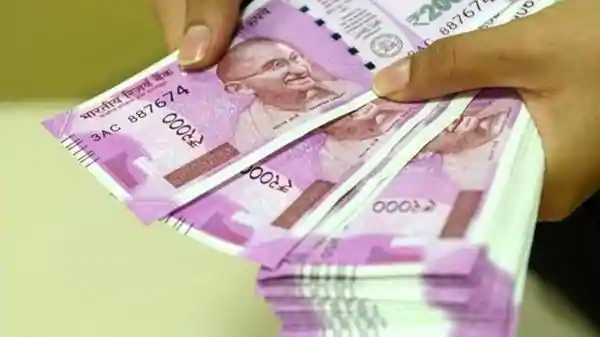 

Stock market prediction is the act of trying to determine the future value of a company stock or other financial instrument traded on an exchange. The successful prediction of a stock's future price could yield significant profit. The efficient market hypothesis posits that stock prices are a function of information and rational expectations, and that newly revealed information about a company's prospects is almost immediately reflected in the current stock price. Predicting how the stock market will perform is one of the most difficult things to do. There are so many factors involved in the prediction – physical factors vs. physhological, rational and irrational behaviour, etc. All these aspects combine to make share prices volatile and very difficult to predict with a high degree of accuracy.

In this endeavor we worked with historical data of the stock prices of few publicly listed companies and implemented a machine learning model based on Long Short Term Memory(LSTM) in order to predict the future prices.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amdgoogle/AMD.csv
/kaggle/input/amdgoogle/GOOGL.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Exploratory Data Analysis(EDA)

When we’re getting started with a machine learning (ML) project, one critical principle to keep in mind is that data is everything. It is often said that if ML is the rocket engine, then the fuel is the (high-quality) data fed to ML algorithms. However, deriving truth and insight from a pile of data can be a complicated and error-prone job. To have a solid start for our ML project, it always helps to analyze the data up front.

During EDA, it’s important that we get a deep understanding of:

* The **properties of the data**, such as schema and statistical properties;
* The **quality of the data**, like missing values and inconsistent data types;
* The **predictive power of the data**, such as correlation of features against target.

This project didn't require profound EDA as the data was time-series. Only thing to enusure in the dataset of AMD were the case missing values. Fortunately, that didn't turn out to be true.

Using pandas info() function of the dataframe structure we found that all rows of the Open prices were filled.

In [3]:
dataset = pd.DataFrame(pd.read_csv("/kaggle/input/amdgoogle/AMD.csv"))

In [4]:
dataset.shape

(2335, 7)

In [5]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,4.43,4.43,4.25,4.26,4.26,8274300
1,2009-05-26,4.26,4.57,4.23,4.53,4.53,16094300
2,2009-05-27,4.57,4.80,4.55,4.71,4.71,21512600
3,2009-05-28,4.75,4.84,4.54,4.70,4.70,18383900
4,2009-05-29,4.71,4.78,4.38,4.54,4.54,24539700


In [6]:
dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2330,2018-08-23,21.190001,22.320000,21.139999,22.290001,22.290001,113444100
2331,2018-08-24,22.910000,24.000000,22.670000,23.980000,23.980000,164328200
2332,2018-08-27,24.940001,27.299999,24.629999,25.260000,25.260000,325058400
2333,2018-08-28,25.510000,26.180000,24.040001,25.049999,25.049999,215771200
2334,2018-08-29,24.360001,25.410000,24.010000,25.200001,25.200001,143079800


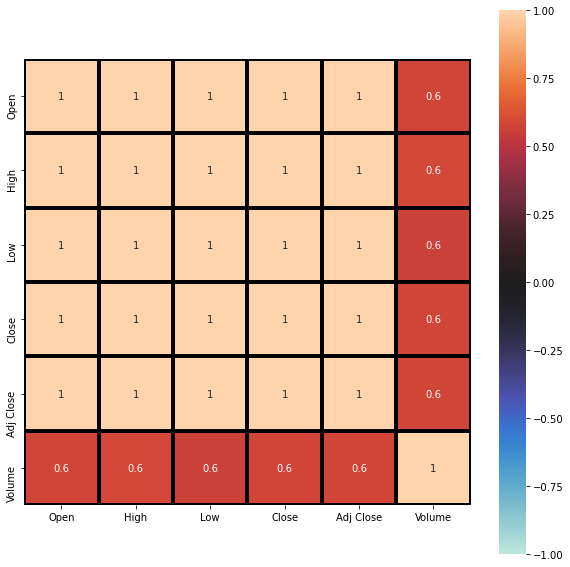

In [7]:
# check for any correlation
plt.figure(figsize = (10,10))
sns.heatmap(dataset.corr(), annot = True, fmt = ".1g", vmin = -1, vmax = 1, center = 0, linewidth = 3,
           linecolor = "black", square = True)

This heat map could be used in order to understand the available stock volume's correlation with other prices(open, close, max, min) for future applications. However, in this project, we keep ourselves to open stock prices prediction based on historical data.

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2335 non-null   object 
 1   Open       2335 non-null   float64
 2   High       2335 non-null   float64
 3   Low        2335 non-null   float64
 4   Close      2335 non-null   float64
 5   Adj Close  2335 non-null   float64
 6   Volume     2335 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 127.8+ KB


There is no missing value. We have full entry.

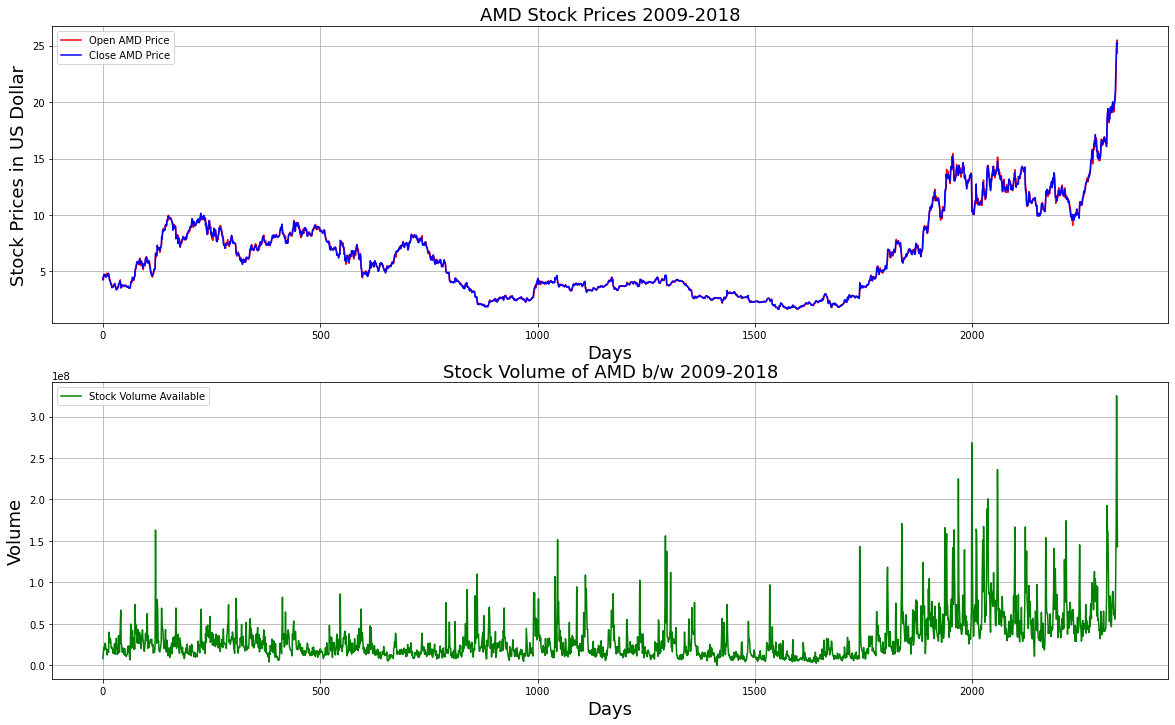

In [9]:
plt.figure(figsize = (20, 12))
x = np.arange(0, dataset.shape[0], 1)
plt.subplot(2,1,1)
plt.plot(x, dataset.Open.values, color = "red", label = "Open AMD Price")
plt.plot(x, dataset.Close.values, color = "blue", label = "Close AMD Price")
plt.title("AMD Stock Prices 2009-2018", fontsize = 18)
plt.xlabel("Days", fontsize = 18)
plt.ylabel("Stock Prices in US Dollar", fontsize = 18)
plt.legend(loc = "best")
plt.grid(which = "major", axis = "both")

plt.subplot(2,1,2)
plt.plot(x, dataset.Volume.values, color = "green", label = "Stock Volume Available")
plt.title("Stock Volume of AMD b/w 2009-2018", fontsize = 18)
plt.xlabel("Days", fontsize = 18)
plt.ylabel("Volume", fontsize = 18)
plt.legend(loc = "best")
plt.grid(which = "major", axis = "both")
plt.show()

# Hyperparameters :

Our machine learning model was based on two hyperparameters which were :

* `Time Step` : Number of days in the past our model looked at in order to predict the price on the asked day. For illustration, if we set time_step = 7 then for predicting the price on **n th day**, our model analyzed all the prices from **n-1** to **n-7 days**. This approach is relatively more accurate than using a traditional machine learning algorithm - such as polynomial linear regression - as we had considered only the recently reported prices rather than the whole dataset at once.

* `Days` : Number of days in the end for which we have to predict the prices for. These were placed in our validation/test set.

In [10]:
TIME_STEP = 7
DAYS = 20 # number of days at the end for which we have to predict. These will be in our validation set.

In [11]:
dataset = pd.DataFrame(pd.read_csv("/kaggle/input/amdgoogle/AMD.csv"))

In [12]:
def dataset_split(dataset) : 
    train = dataset[0: len(dataset) - DAYS]
    val = dataset[len(dataset) - DAYS - TIME_STEP : len(dataset)]
    return train, val

In [13]:
dataset.drop(["Date","High", "Low", "Close", "Volume", "Adj Close"], axis = 1, inplace = True)
dataset = dataset.values

# Scaling :

It refers to putting the values in the same range or same scale so that no variable is dominated by the other.

Most of the times, our dataset contains features highly varying in magnitudes, units and range. But since, most of the machine learning algorithms use Euclidean distance between two data points in their computations, this poses to be a problem. If left alone, these algorithms only take in the magnitude of features neglecting the units. The results would vary greatly between different units, 5kg and 5000gms *for illustration. The features with high magnitudes will weigh in a lot more in the distance calculations than features with low magnitudes. To suppress this effect, we need to bring all features to the same level of magnitudes. This can be achieved by scaling.*

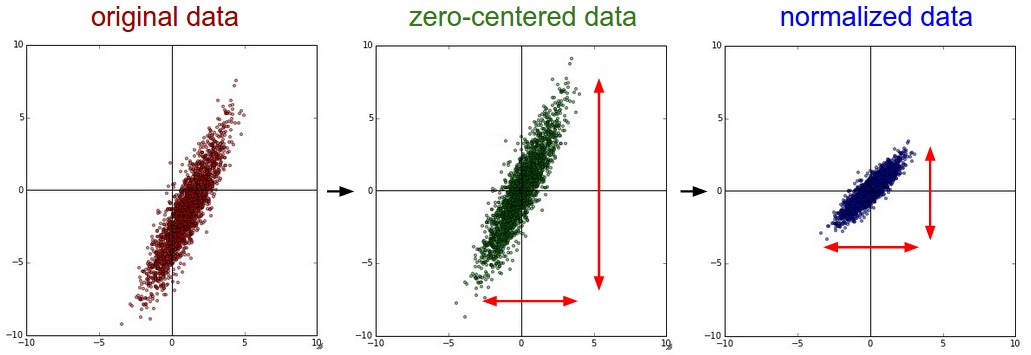

In a nutshell, scaling helps our optimization algorithm converge faster on our data. **In the figure we can see the skeweness of the data distribution decreases a lot after scaling, as a result of which gradient descent(optimization algorithm) converges faster.**

For scaling we will import the scikit-learn Python3 machine learning library where **we use MinMaxScaler to scale all the price values beteen 0 and 1, that is the feature range we provided in the code.**

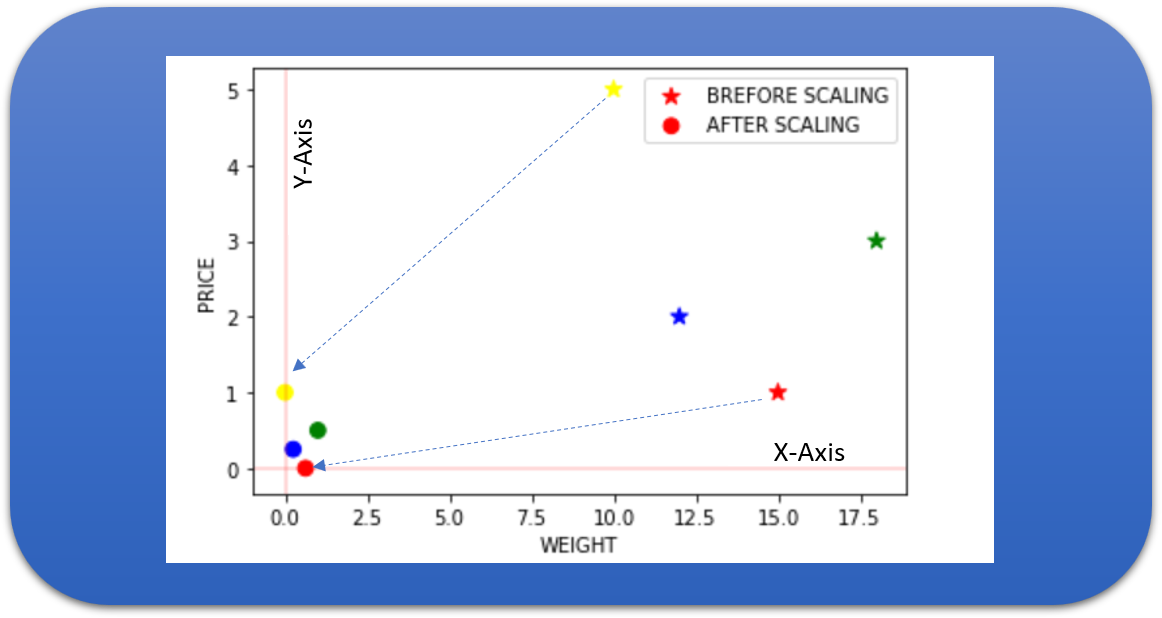

In [14]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
dataset_scaled = scaler.fit_transform(dataset)

In [15]:
train, val = dataset_split(dataset_scaled)

In [16]:
train.shape, val.shape

((2315, 1), (27, 1))

# Configuring The Dataset For Deep Learning :

Since we had planned to use an LSTM model for time-series prediction, the conversion of dataset's shape from 1-D to 3-D tensor became mandatory. For this we grouped the values from the past **time_step** days into one and stacked such units one behind the other.

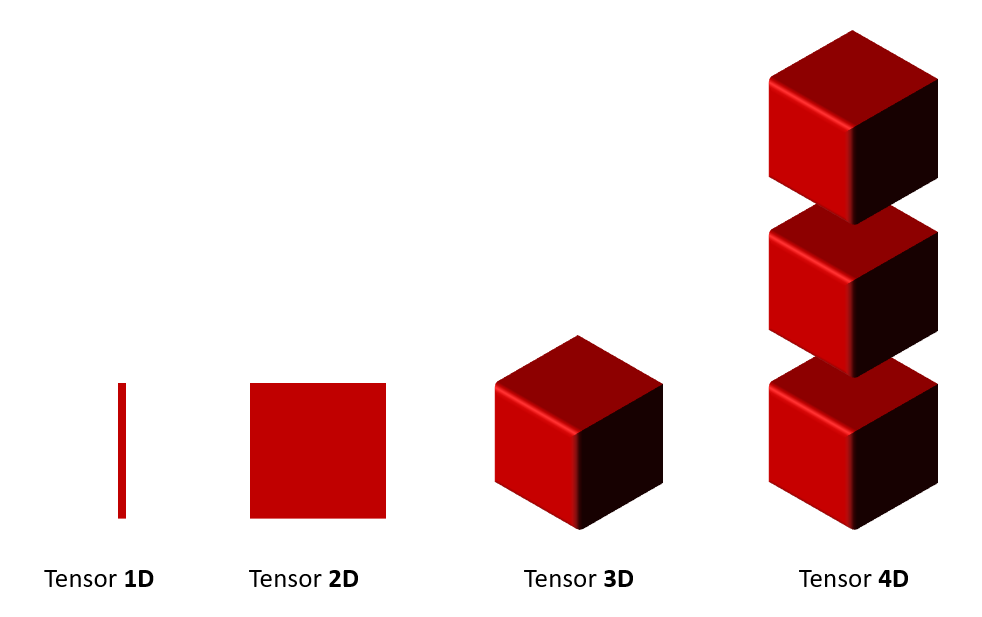

In [17]:
train_x, train_y = [], []
for i in range(TIME_STEP, train.shape[0]) : 
    train_x.append(train[i - TIME_STEP : i, 0])
    train_y.append(train[i, 0])
train_x, train_y = np.array(train_x), np.array(train_y)

In [18]:
val_x, val_y = [], []
for i in range(TIME_STEP, val.shape[0]) : 
    val_x.append(val[i - TIME_STEP : i, 0])
    val_y.append(val[i, 0])
val_x, val_y = np.array(val_x), np.array(val_y)

In [19]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
val_x = np.reshape(val_x, (val_x.shape[0], val_x.shape[1], 1))
print("Reshaped train_x = ", train_x.shape)
print("Shape of train_y = ", train_y.shape)

print("Reshaped val_x = ", val_x.shape)
print("Shape of val_y = ", val_y.shape)

Reshaped train_x =  (2308, 7, 1)
Shape of train_y =  (2308,)
Reshaped val_x =  (20, 7, 1)
Shape of val_y =  (20,)


# Long Short Term Memory - LSTM :

Humans don’t start their thinking from scratch every second. As we read this paragraph, we understand each word based on our understanding of previous words. We don’t throw everything away and start thinking from scratch again. Our thoughts have persistence. Traditional neural networks can’t do this, and it seems like a major shortcoming.

Recurrent Neural Networks(RNNs) address this issue. They are networks with loops in them, allowing information to persist.

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies.

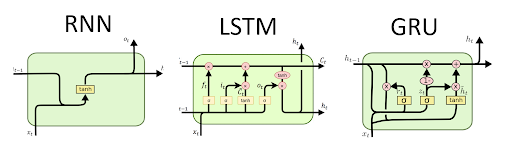 

The entire process of the working behind a RNN is beautifully illustrated at : https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Using Keras API of Tensorflow a model was prepared having layers of LSTM cells stacked onto each other followed by a general Artificial Neural Network(ANN).

* ReLU activation function was used in all the layers with dropout ranging from 0.2-0.4.
* Adam Optimizer and MSE(Mean Squared Error) loss function was used.

In [20]:
import tensorflow as tf

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.list_physical_devices("GPU")
print(gpus)
if len(gpus) == 1 : 
    strategy = tf.distribute.OneDeviceStrategy(device = "/gpu:0")
else:
    strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision" : True})
print("Mixed precision enabled")

Mixed precision enabled


In [23]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= "loss", factor = 0.5, patience = 10,
                                                 min_lr = 0.000001, verbose = 1)
monitor_es = tf.keras.callbacks.EarlyStopping(monitor= "loss", patience = 25, restore_best_weights= False, verbose = True)

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 128, return_sequences = True, input_shape = (train_x.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(units = 128, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(units = 128, return_sequences = False))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(units = 10, activation = "relu"))
model.add(tf.keras.layers.Dense(units = 1, activation = "relu"))

In [25]:
model.compile(tf.keras.optimizers.Adam(lr = 0.001), loss = "mean_squared_error")

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            66560     
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [27]:
with tf.device("/device:GPU:0"):
    history = model.fit(train_x, train_y, epochs = 300, batch_size = 16, callbacks = [reduce_lr, monitor_es])

Epoch 1/300
145/145 [==============================] - 1s 6ms/step - loss: 0.0039 - lr: 0.0010
Epoch 2/300
145/145 [==============================] - 1s 6ms/step - loss: 0.0012 - lr: 0.0010
Epoch 3/300
145/145 [==============================] - 1s 6ms/step - loss: 0.0012 - lr: 0.0010
Epoch 4/300
145/145 [==============================] - 1s 6ms/step - loss: 9.3100e-04 - lr: 0.0010
Epoch 5/300
145/145 [==============================] - 1s 6ms/step - loss: 9.3495e-04 - lr: 0.0010
Epoch 6/300
145/145 [==============================] - 1s 6ms/step - loss: 8.0226e-04 - lr: 0.0010
Epoch 7/300
145/145 [==============================] - 1s 6ms/step - loss: 8.2965e-04 - lr: 0.0010
Epoch 8/300
145/145 [==============================] - 1s 6ms/step - loss: 8.3004e-04 - lr: 0.0010
Epoch 9/300
145/145 [==============================] - 1s 6ms/step - loss: 7.0440e-04 - lr: 0.0010
Epoch 10/300
145/145 [==============================] - 1s 6ms/step - loss: 6.7963e-04 - lr: 0.0010
Epoch 11/300
145/145 

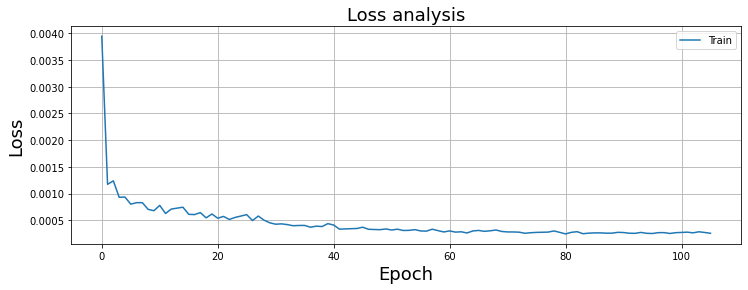

In [28]:
plt.figure(figsize = (12, 4))
plt.plot(history.history["loss"], label = "Training loss")
plt.title("Loss analysis", fontsize = 18)
plt.xlabel("Epoch", fontsize = 18)
plt.ylabel("Loss", fontsize = 18)
plt.legend(["Train"])
plt.grid("both")

Save the model

In [29]:
model_json = model.to_json()
with open("AMD_open_1.json", "w") as json_file:
  json_file.write(model_json)

model.save_weights("AMD_open_1.h5")

Load the model

In [30]:
# get model
from keras.models import model_from_json
json_file = open('AMD_open_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("AMD_open_1.h5")
print("Loaded model from disk")
loaded_model.compile(loss='mean_squared_error', optimizer='adam')

Using TensorFlow backend.


Loaded model from disk


In [31]:
real_prices = val[TIME_STEP:]
real_prices = scaler.inverse_transform(real_prices)

In [32]:
predicted_prices = loaded_model.predict(val_x)
predicted_prices = scaler.inverse_transform(predicted_prices)

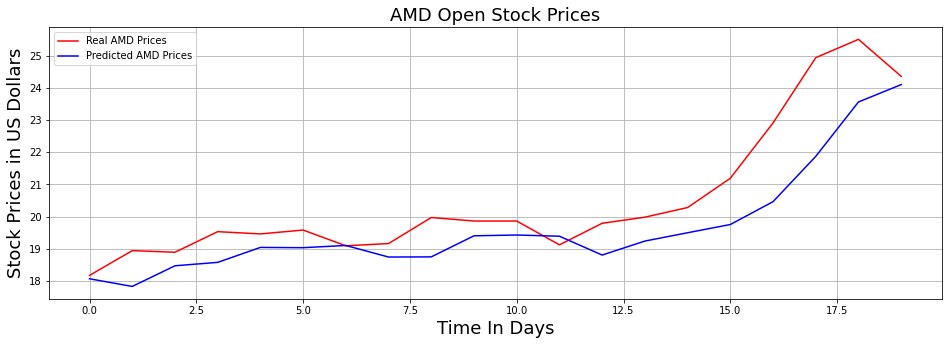

In [33]:
plt.figure(figsize= (16, 5))
plt.subplot(1,1,1)

x = np.arange(0, DAYS, 1)

plt.plot(x, real_prices, color = "red", label = "Real AMD Prices")
plt.plot(x, predicted_prices, color = "blue", label = "Predicted AMD Prices")
plt.title("AMD Open Stock Prices", fontsize = 18)
plt.xlabel("Time In Days", fontsize = 18)
plt.ylabel("Stock Prices in US Dollars", fontsize = 18)
plt.legend()
plt.grid("both")

In [34]:
original_training_prices = scaler.inverse_transform(train)
original_training_prices

array([[ 4.43],
       [ 4.26],
       [ 4.57],
       ...,
       [19.4 ],
       [19.35],
       [18.34]])

In [35]:
x1 = np.arange(0,len(original_training_prices),1)
x2 = np.arange(len(original_training_prices), len(dataset), 1)
print(len(x1), len(x2))

2315 20


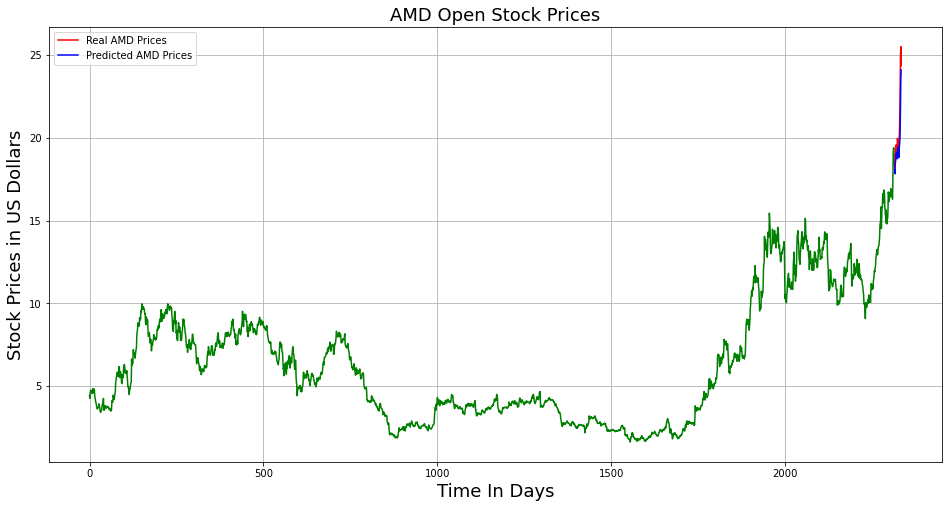

In [36]:
plt.figure(figsize= (16,8))
plt.subplot(1,1,1)

X = len(dataset)
x1 = np.arange(0,len(original_training_prices),1)
x2 = np.arange(len(original_training_prices), len(dataset), 1)

plt.plot(x1, original_training_prices, color = "green")
plt.plot(x2, real_prices, color = "red", label = "Real AMD Prices")
plt.plot(x2, predicted_prices, color = "blue", label = "Predicted AMD Prices")
plt.title("AMD Open Stock Prices", fontsize = 18)
plt.xlabel("Time In Days", fontsize = 18)
plt.ylabel("Stock Prices in US Dollars", fontsize = 18)
plt.legend()
plt.grid("both")

We successfully trained a deep learning architecture based on state of the art LSTM networks in order to predict the prices based on historical understanding of our data.

Thank you!!
Upvote if you find it insightful :-)